In [16]:
import google.generativeai as genai
import os
from PIL import Image
import csv
import time
import re
import matplotlib.pyplot as plt
import pandas as pd 
import traceback # For detailed error printing
from google.generativeai import types

# --- Configuration ---
print("--- Setting up Configuration ---")
# IMPORTANT: Set your API Key securely via environment variable BEFORE launching Jupyter.
# Example in terminal: export GEMINI_API_KEY="YOUR_API_KEY"
API_KEY = os.getenv("GEMINI_API_KEY")
if not API_KEY:
    print("CRITICAL WARNING: GEMINI_API_KEY environment variable not set.")
    if not API_KEY:
         raise ValueError("API Key not found. Please set the GEMINI_API_KEY environment variable.")
else:
    print("API Key found.")

# --- Paths ---
IMAGE_FOLDER = "/workspaces/t/XTR Val"
LABELS_FILE = "/workspaces/t/XTR Val labels.txt" 
OUTPUT_CSV = "gemini_stroke_predictions_notebook.csv"
print(f"Image Folder: {IMAGE_FOLDER}")
print(f"Labels File: {LABELS_FILE}")
print(f"Output CSV: {OUTPUT_CSV}")

# --- Model Selection ---
MODEL_NAME = 'gemini-2.0-flash'
print(f"Using Model: {MODEL_NAME}")

# --- API Settings ---
genai.configure(api_key=API_KEY)

# --- Remove Safety Settings Temporarily ---
safety_settings = None
print("Safety Settings set to None for testing.")

# --- Generation configuration (Low temperature for consistency) ---
generation_config = genai.types.GenerationConfig(
    temperature=0.1, # Closer to 0 = more deterministic
    max_output_tokens=10 # We only need '0' or '1'
)
print(f"Generation Config: Temperature={generation_config.temperature}, Max Tokens={generation_config.max_output_tokens}")
print(f"Safety Settings: set to None (using API defaults)")

# --- Rate Limiting Settings ---
PAUSE_INTERVAL = 15 # Pause every N images processed
PAUSE_DURATION = 60  # Pause for N seconds -1 minute-

print(f"Pausing every {PAUSE_INTERVAL} images for {PAUSE_DURATION} seconds to manage rate limits.")


# --- Display Settings ---
MAX_IMAGES_TO_DISPLAY = 10 # Limit inline image display
IMAGE_FILE_EXTENSION = ".png" 
print(f"Max images to display inline: {MAX_IMAGES_TO_DISPLAY}")
print(f"Expected image file extension: {IMAGE_FILE_EXTENSION}")

print("--- Configuration Done ---")

--- Setting up Configuration ---
API Key found.
Image Folder: /workspaces/t/XTR Val
Labels File: /workspaces/t/XTR Val labels.txt
Output CSV: gemini_stroke_predictions_notebook.csv
Using Model: gemini-2.0-flash
Safety Settings set to None for testing.
Generation Config: Temperature=0.1, Max Tokens=10
Safety Settings: set to None (using API defaults)
Pausing every 15 images for 60 seconds to manage rate limits.
Max images to display inline: 10
Expected image file extension: .png
--- Configuration Done ---


In [18]:
import pandas as pd
import traceback
import os 

# Function definition first
def load_ground_truth(label_filepath, expected_extension=".png"):
    """
    Loads labels from the specific tab-delimited file format provided:
    Header: "Image Id\tİnme Var mı?"
    Data: "10189\t0"
    Maps Image Filename (constructed from 'Image Id' + extension) to Label ('0' or '1').

    Args:
        label_filepath (str): Path to the label file.
        expected_extension (str): The expected file extension for image files (e.g., ".png").

    Returns:
        dict: A dictionary mapping full image filenames (e.g., "10189.png") to labels ('0' or '1').
              Returns None if loading fails critically.
    """
    print(f"--- Loading Ground Truth Labels from: {label_filepath} ---")
    ground_truth = {}
    # --- Define EXPECTED column names based on the labels file ---
    expected_id_col = "Image Id"
    expected_label_col = "İnme Var mı?"
    print(f"    Expecting ID column: '{expected_id_col}', Label column: '{expected_label_col}'")

    try:
        # --- Use sep='\t' and explicit dtype with expected names ---
        dtypes_to_use = {
            expected_id_col: str,
            expected_label_col: str
        }
        print(f"    Reading file with specified delimiter '\\t' and string dtypes for expected columns.")

        df = pd.read_csv(
            label_filepath,
            sep='\t', # Explicitly use TAB as the separator
            engine='python', # Often good practice with specific separators
            dtype=dtypes_to_use # Read ID and Label as strings directly
        )

        print(f"    Successfully read file using pandas. Columns found: {list(df.columns)}")

        # Verify that the expected columns actually exist after reading
        if expected_id_col not in df.columns:
             print(f"    CRITICAL Error: Expected ID column '{expected_id_col}' not found in the file header.")
             return None
        if expected_label_col not in df.columns:
             print(f"    CRITICAL Error: Expected Label column '{expected_label_col}' not found in the file header.")
             return None

        print(f"    Processing rows using detected columns...")
        processed_count = 0
        skipped_count = 0
        for index, row in df.iterrows():
            try:
                # Values should be strings because of dtype=str
                image_id = row[expected_id_col].strip() # Use exact column name
                label = row[expected_label_col].strip()   # Use exact column name again

                # Construct the expected filename like "10189.png"
                filename = f"{image_id}{expected_extension}"

                # Validate the label is strictly '0' or '1'
                if label in ['0', '1']:
                    ground_truth[filename] = label
                    processed_count += 1
                else:
                    print(f"    Warning: Row {index + 2}: Invalid label value '{label}' (expected '0' or '1') for ID '{image_id}'. Skipping.")
                    skipped_count += 1
            except KeyError as ke:
                # This shouldn't happen if columns were verified, but good safety check
                 print(f"    Warning: Row {index + 2}: Error accessing expected column -> {ke}. Skipping.")
                 skipped_count += 1
            except Exception as row_e:
                print(f"    Warning: Row {index + 2}: Error processing -> {row_e}. Skipping.")
                skipped_count += 1

        print(f"    Loaded {processed_count} valid labels. Skipped {skipped_count} rows due to invalid label values or processing errors.")
        if processed_count > 0:
             print("    First 5 loaded labels:", dict(list(ground_truth.items())[:5]))
        else:
             print("    Warning: No valid labels were loaded. Please check file content against expectations.")
             
             return None

    except FileNotFoundError:
        print(f"    CRITICAL Error: Label file not found at {label_filepath}")
        return None
    except Exception as e:
        print(f"    CRITICAL Error reading or processing label file: {e}")
        traceback.print_exc() # Print full details for debugging
        return None
    print("--- Ground Truth Loading Done ---")
    return ground_truth

# --- Execution part ---
try:
    ground_truth_labels = load_ground_truth(LABELS_FILE, expected_extension=IMAGE_FILE_EXTENSION)

    if ground_truth_labels is None:
        print("\nCRITICAL FAILURE: Could not load ground truth labels. Label comparison will not work.")
    elif not ground_truth_labels: # Check if dictionary is empty even if not None
         print("\nWarning: Ground truth label loading finished, but the resulting label dictionary is empty.")
    else:
        print(f"\nSuccessfully loaded {len(ground_truth_labels)} ground truth labels into memory.")

except NameError as ne:
     print(f"\nERROR: A necessary variable (like LABELS_FILE or IMAGE_FILE_EXTENSION) was not defined before calling load_ground_truth.")
     print(f"       Please ensure Cell 1 defines these variables. Specific error: {ne}")
     raise # Stop execution
except Exception as e_call:
     print(f"\nERROR: An unexpected error occurred when calling load_ground_truth: {e_call}")
     traceback.print_exc()
     raise # Stop execution

--- Loading Ground Truth Labels from: /workspaces/t/XTR Val labels.txt ---
    Expecting ID column: 'Image Id', Label column: 'İnme Var mı?'
    Reading file with specified delimiter '\t' and string dtypes for expected columns.
    Successfully read file using pandas. Columns found: ['Image Id', 'İnme Var mı?']
    Processing rows using detected columns...
    Loaded 200 valid labels. Skipped 0 rows due to invalid label values or processing errors.
    First 5 loaded labels: {'10189.png': '0', '10200.png': '0', '10231.png': '0', '10267.png': '0', '10300.png': '0'}
--- Ground Truth Loading Done ---

Successfully loaded 200 ground truth labels into memory.


In [ ]:
def get_gemini_prediction(image_path, model, image_object):
    """
    Sends an image object to the configured Gemini model and asks for stroke prediction.

    Args:
        image_path (str): Path to the image file (for logging filename).
        model: The initialized Gemini model instance.
        image_object (PIL.Image): The loaded PIL Image object.

    Returns:
        tuple: (predicted_label, raw_response_text)
               predicted_label is '0', '1', 'Unclear', 'Blocked', or 'Error'
               raw_response_text is the full text response or error message.
    """
    filename = os.path.basename(image_path)
    print(f"\n--- Processing Image: {filename} ---")
    try:
        # --- Prompt Definition (Uses the passed image_object) ---
        prompt = [
            "You are an AI assistant specialized in analyzing medical images for predefined visual patterns.",
            image_object, # Pass the PIL image object directly
            "Task: Analyze the provided single Non-Contrast Computed Tomography (NCCT) brain scan slice.",
            "Objective: Determine if there are *clear visual signs* suggestive of *any type of stroke* present within this single image slice.",
            "Focus *exclusively* on the visual evidence in this image.",
            "Signs to Look For:",
            " 1. Abnormal Density: Look for any distinct brain tissue region that is significantly darker (hypodense) or significantly brighter (hyperdense) than expected for normal brain tissue in that location (excluding normal structures like bone or obvious calcification, unless hyperdensity suggests hemorrhage).",
            " 2. Structural Changes / Mass Effect: Identify significant asymmetry between hemispheres, localized swelling causing effacement (flattening) of brain surface grooves (sulci), compression or displacement of the fluid spaces (ventricles), or shifting of the brain's midline.",
            " 3. Loss of Definition: Check for blurring or loss of the normal clear boundary between grey matter and white matter.",
            "Internal Reasoning Steps (Follow these steps mentally *before* giving your final answer. Do *not* output these steps or your reasoning):",
            "  a. Plan: Briefly outline a mental checklist to systematically scan the image for the 'Signs to Look For' mentioned above (density abnormalities, structural changes, loss of definition).",
            "  b. Execute & Reason: Mentally examine the image according to your plan. Note any visual evidence corresponding to the listed signs. Evaluate the clarity and significance of these findings.",
            "  c. Conclude: Based *only* on the clear visual evidence identified in step 'b', decide if one or more signs strongly suggest the presence of a stroke.",
            "Constraints: Base your final output *solely* on unambiguous visual evidence present in *this single image*. Do not infer information beyond this image. Ignore subtle findings or artifacts.",
            "Question: Based on your internal analysis of the visual evidence, are there clear signs suggestive of a stroke in this image?",
            "Required Output: Your entire response must consist of *only* the single digit `0` (if NO clear signs are found) or the single digit `1` (if YES, clear signs are found). Do not include any other text, explanation, or punctuation."
        ]
        # --- End Prompt ---
        

        print(f"    Sending prompt and image to Gemini model ({model.model_name})...")
        start_time = time.time()

        # Make the API call
        response = model.generate_content(
            prompt,
            generation_config=generation_config,
            safety_settings=safety_settings,
            stream=False # Get response all at once
        )

        end_time = time.time()
        print(f"    Received response from Gemini in {end_time - start_time:.2f} seconds.")

        # --- Parse the response ---
        prediction = "Error" # Default state
        raw_text = "Error: Parsing Failed" # Default state

        try:
            # Check for safety blocks or empty responses first
            if not response.parts:
                 block_reason = "Unknown blocking reason"
                 if hasattr(response, 'prompt_feedback') and response.prompt_feedback.block_reason:
                     block_reason = response.prompt_feedback.block_reason
                 print(f"    Warning: Response was blocked or empty. Reason: {block_reason}")
                 return "Blocked", f"Blocked: {block_reason}"

            # If response has parts, try to get text
            raw_text = response.text.strip()
            print(f"    Gemini Raw Response: '{raw_text}'") # Debugging print

            # Check for exact '0' or '1'
            if raw_text == '1':
                prediction = '1'
                print(f"    Parsed Prediction: 1 (Stroke Signs Suspected)")
            elif raw_text == '0':
                prediction = '0'
                print(f"    Parsed Prediction: 0 (No Clear Stroke Signs)")
            else:
                # Handle cases where the model didn't strictly comply
                print(f"    Warning: Non-compliant response: '{raw_text}'. Expected '0' or '1'. Recording as 'Unclear'.")
                prediction = "Unclear"
                # Keep raw_text as is for logging

            return prediction, raw_text

        except ValueError as ve:
             # Handle cases where accessing response.text fails (often due to blocking)
             print(f"    Error accessing response text for {filename}. Possible blocking. Error: {ve}")
             block_reason = "Unknown"
             if hasattr(response, 'prompt_feedback') and response.prompt_feedback.block_reason:
                 block_reason = response.prompt_feedback.block_reason
             return "Blocked", f"Access Error/Blocked: {block_reason}"
        except Exception as e: # Catch other potential errors during parsing
            print(f"    Error parsing Gemini response for {filename}: {e}")
            traceback.print_exc()
            return "Error", f"Parsing Error: {e}"

    except FileNotFoundError: # Should be caught before calling, but safety first
        print(f"    Error: Image file seems to be missing: {image_path}")
        return "Error", "File Not Found During Processing"
    except Exception as e:
        # Catch API errors, connection issues, etc.
        print(f"    CRITICAL Error processing {filename} with Gemini API: {e}")
        traceback.print_exc()
        return "Error", f"API Error: {str(e)}"

print("--- Gemini Interaction Function Defined ---")

--- Gemini Interaction Function Defined ---



--- Starting Main Processing Loop ---
Initializing Gemini model: gemini-2.0-flash...
Model 'models/gemini-2.0-flash' initialized successfully.
Looking for images with extension '.png' in: /workspaces/t/XTR Val
Found 200 image files to process.
Processing images and saving predictions to: gemini_stroke_predictions_notebook.csv
Output CSV file 'gemini_stroke_predictions_notebook.csv' opened with header: ['filename', 'ground_truth', 'gemini_prediction', 'gemini_raw_response']

>>> Processing image 1/200: 10007.png <<<
    Loading image: /workspaces/t/XTR Val/10007.png
    Ground Truth Label: 1

--- Processing Image: 10007.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 1.05 seconds.
    Gemini Raw Response: '1'
    Parsed Prediction: 1 (Stroke Signs Suspected)
    Result for 10007.png written to CSV.
    Displaying image 1/10...


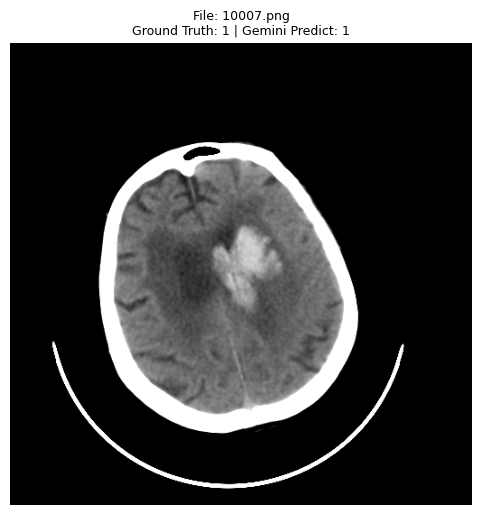

    Display complete.
    Pausing for 1.5 sec...



>>> Processing image 2/200: 10029.png <<<
    Loading image: /workspaces/t/XTR Val/10029.png
    Ground Truth Label: 1

--- Processing Image: 10029.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.75 seconds.
    Gemini Raw Response: '1'
    Parsed Prediction: 1 (Stroke Signs Suspected)
    Result for 10029.png written to CSV.
    Displaying image 2/10...


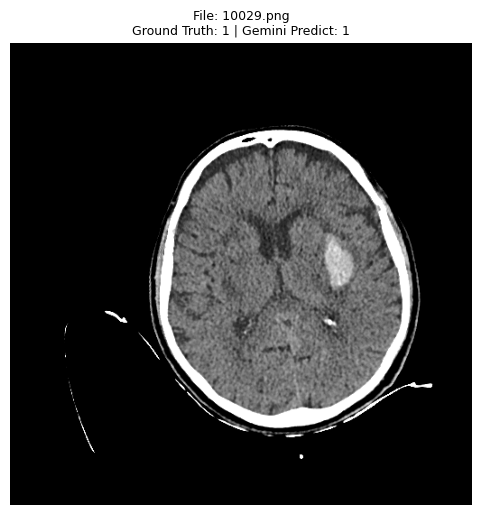

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 3/200: 10189.png <<<
    Loading image: /workspaces/t/XTR Val/10189.png
    Ground Truth Label: 0

--- Processing Image: 10189.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.89 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10189.png written to CSV.
    Displaying image 3/10...


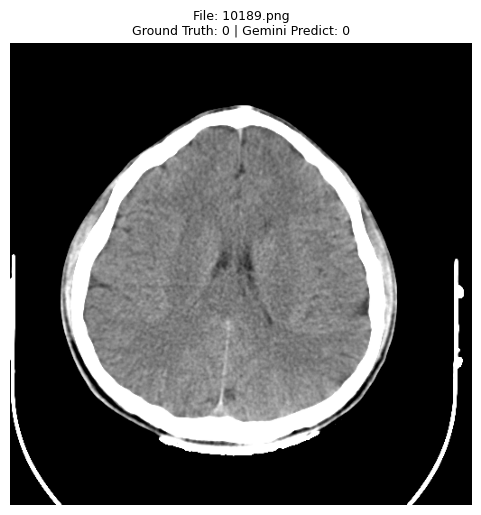

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 4/200: 10200.png <<<
    Loading image: /workspaces/t/XTR Val/10200.png
    Ground Truth Label: 0

--- Processing Image: 10200.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.49 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10200.png written to CSV.
    Displaying image 4/10...


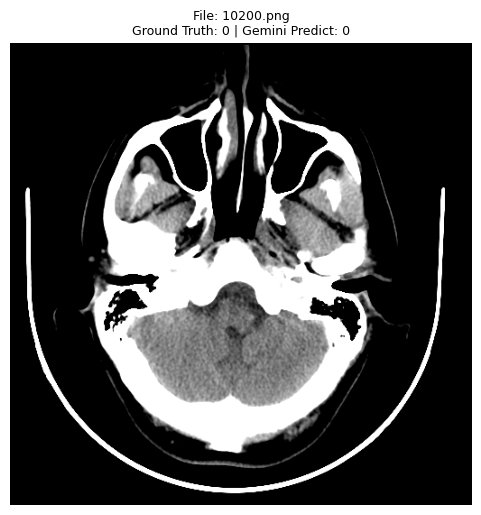

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 5/200: 10231.png <<<
    Loading image: /workspaces/t/XTR Val/10231.png
    Ground Truth Label: 0

--- Processing Image: 10231.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.55 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10231.png written to CSV.
    Displaying image 5/10...


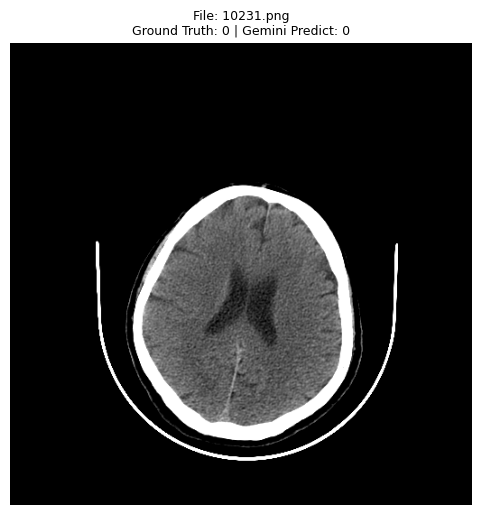

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 6/200: 10241.png <<<
    Loading image: /workspaces/t/XTR Val/10241.png
    Ground Truth Label: 1

--- Processing Image: 10241.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.66 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10241.png written to CSV.
    Displaying image 6/10...


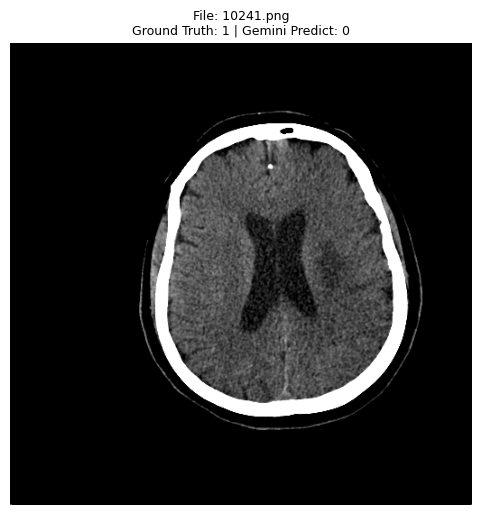

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 7/200: 10267.png <<<
    Loading image: /workspaces/t/XTR Val/10267.png
    Ground Truth Label: 0

--- Processing Image: 10267.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 1.12 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10267.png written to CSV.
    Displaying image 7/10...


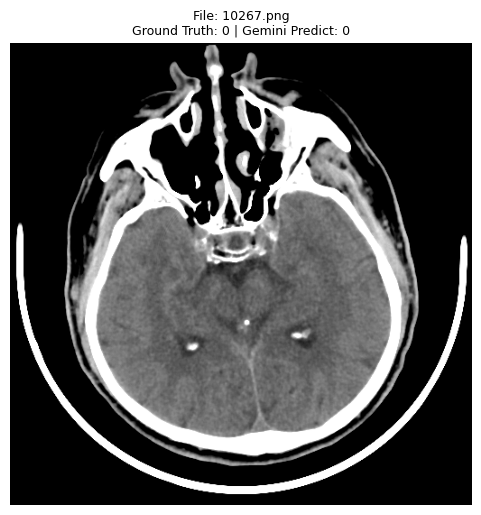

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 8/200: 10300.png <<<
    Loading image: /workspaces/t/XTR Val/10300.png
    Ground Truth Label: 0

--- Processing Image: 10300.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.62 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10300.png written to CSV.
    Displaying image 8/10...


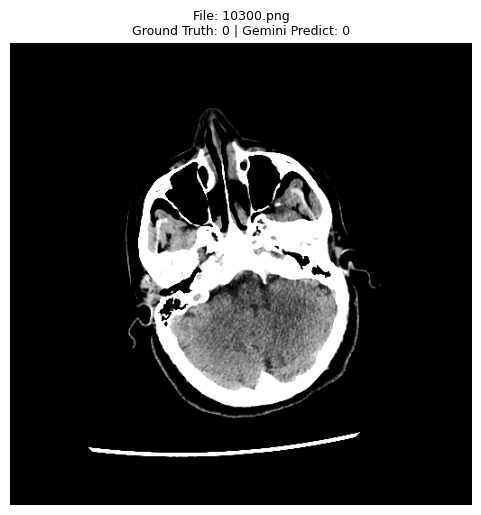

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 9/200: 10301.png <<<
    Loading image: /workspaces/t/XTR Val/10301.png
    Ground Truth Label: 0

--- Processing Image: 10301.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.93 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10301.png written to CSV.
    Displaying image 9/10...


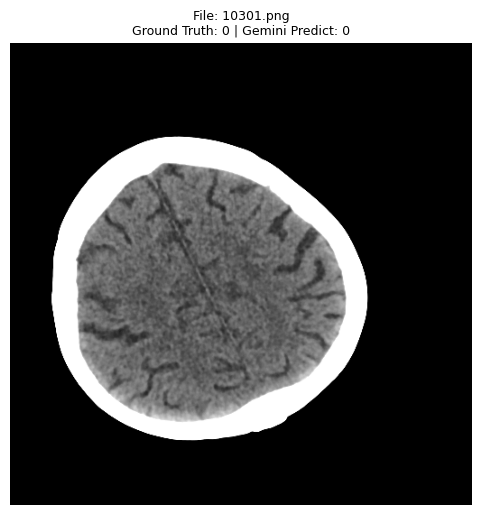

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 10/200: 10319.png <<<
    Loading image: /workspaces/t/XTR Val/10319.png
    Ground Truth Label: 0

--- Processing Image: 10319.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.84 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10319.png written to CSV.
    Displaying image 10/10...


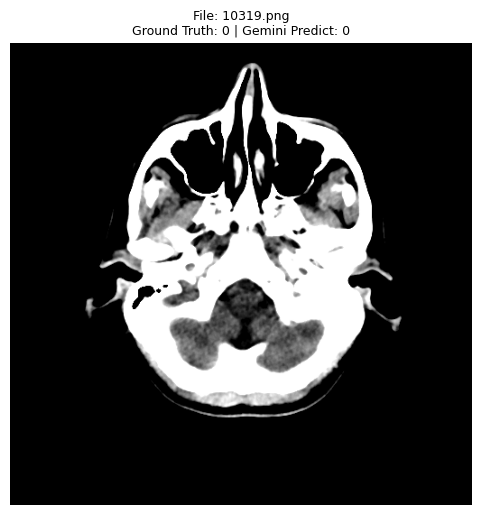

    Display complete.
    Pausing for 1.5 sec...

>>> Processing image 11/200: 10360.png <<<
    Loading image: /workspaces/t/XTR Val/10360.png
    Ground Truth Label: 0

--- Processing Image: 10360.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 1.11 seconds.
    Gemini Raw Response: '0'
    Parsed Prediction: 0 (No Clear Stroke Signs)
    Result for 10360.png written to CSV.
    Pausing for 1.5 sec...

>>> Processing image 12/200: 10437.png <<<
    Loading image: /workspaces/t/XTR Val/10437.png
    Ground Truth Label: 1

--- Processing Image: 10437.png ---
    Sending prompt and image to Gemini model (models/gemini-2.0-flash)...
    Received response from Gemini in 0.91 seconds.
    Gemini Raw Response: '1'
    Parsed Prediction: 1 (Stroke Signs Suspected)
    Result for 10437.png written to CSV.
    Pausing for 1.5 sec...

>>> Processing image 13/200: 10461.png <<<
    Loading image: /workspaces/t/XTR Val/10461.p

In [20]:
print("\n--- Starting Main Processing Loop ---")

# --- Initialize Gemini Model ---
print(f"Initializing Gemini model: {MODEL_NAME}...")
try:
    # Ensure model name from Cell 1 is used
    model = genai.GenerativeModel(MODEL_NAME)
    print(f"Model '{model.model_name}' initialized successfully.")
except Exception as e:
    print(f"CRITICAL Error initializing Gemini model ({MODEL_NAME}): {e}")
    print("Please check the model name and your API key/access in Cell 1.")
    raise SystemExit("Stopping due to model initialization failure.")

# --- Find Image Files ---
print(f"Looking for images with extension '{IMAGE_FILE_EXTENSION}' in: {IMAGE_FOLDER}")
if not os.path.isdir(IMAGE_FOLDER):
     print(f"CRITICAL Error: Image folder not found: {IMAGE_FOLDER}")
     raise SystemExit("Stopping because image folder is missing.")

try:
    all_files = os.listdir(IMAGE_FOLDER)
    image_files = sorted([
        f for f in all_files
        if os.path.isfile(os.path.join(IMAGE_FOLDER, f)) and f.lower().endswith(IMAGE_FILE_EXTENSION)
    ])
    if not image_files:
        print(f"CRITICAL Error: No '{IMAGE_FILE_EXTENSION}' files found in {IMAGE_FOLDER}")
        raise SystemExit("Stopping because no image files were found.")
    else:
        print(f"Found {len(image_files)} image files to process.")
except Exception as e:
    print(f"CRITICAL Error listing files in {IMAGE_FOLDER}: {e}")
    raise SystemExit("Stopping due to error listing image files.")


# --- Process Images and Write to CSV ---
results = [] # Store results for final summary
images_processed_count = 0
images_displayed_count = 0
error_count_loop = 0
pause_counter = 0  # Add the pause counter

print(f"Processing images and saving predictions to: {OUTPUT_CSV}")

try:
    with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header matching the data we collect
        header = ['filename', 'ground_truth', 'gemini_prediction', 'gemini_raw_response']
        csv_writer.writerow(header)
        print(f"Output CSV file '{OUTPUT_CSV}' opened with header: {header}")

        # Iterate through discovered image files
        for filename in image_files:
            images_processed_count += 1
            pause_counter += 1 # Increment the pause counter

            print(f"\n>>> Processing image {images_processed_count}/{len(image_files)}: {filename} <<<")
            image_path = os.path.join(IMAGE_FOLDER, filename)

            # Defaults for this iteration
            prediction = "Error"
            raw_response = "Processing Error"
            ground_truth = "Not Found" # Default if label missing or file failed load

            # --- Core processing block for one image ---
            try:
                # 1. Load the image using PIL
                print(f"    Loading image: {image_path}")
                img_pil = Image.open(image_path)

                # 2. Get ground truth label 
                if ground_truth_labels is not None:
                    # Use .get() for safe lookup, provide default if key (filename) missing
                    ground_truth = ground_truth_labels.get(filename, "Not Found In Labels")
                else:
                    ground_truth = "Labels Unavailable" # Labels failed to load earlier

                print(f"    Ground Truth Label: {ground_truth}")

                # 3. Get prediction from Gemini
                prediction, raw_response = get_gemini_prediction(image_path, model, img_pil)

                # 4. Write result row immediately to CSV
                # Ensure order matches header: filename, ground_truth, gemini_prediction, gemini_raw_response
                csv_writer.writerow([filename, ground_truth, prediction, raw_response])
                print(f"    Result for {filename} written to CSV.")

                # 5. Append details to results list for summary later
                results.append({
                    'filename': filename,
                    'ground_truth': ground_truth,
                    'prediction': prediction,
                    'raw_response': raw_response
                })

                # 6. Display Image, GT, and Prediction -for the first few-
                if images_displayed_count < MAX_IMAGES_TO_DISPLAY:
                    images_displayed_count += 1
                    print(f"    Displaying image {images_displayed_count}/{MAX_IMAGES_TO_DISPLAY}...")
                    try:
                        plt.figure(figsize=(6, 6)) # Adjust size as needed
                        plt.imshow(img_pil, cmap='gray') # Use grayscale colormap for NCCT
                        title_text = f"File: {filename}\nGround Truth: {ground_truth} | Gemini Predict: {prediction}"
                        # Handle long raw responses in title if prediction was unclear/error
                        if prediction in ["Unclear", "Error", "Blocked"] and len(raw_response) > 50:
                             title_text += f"\nRaw: {raw_response[:50]}..." # Truncate long raw responses
                        elif prediction in ["Unclear", "Error", "Blocked"]:
                             title_text += f"\nRaw: {raw_response}"

                        plt.title(title_text, fontsize=9)
                        plt.axis('off') # Hide axes
                        plt.show() # Display the plot in the notebook output
                        print("    Display complete.")
                    except Exception as display_e:
                         print(f"    Warning: Failed to display image {filename}: {display_e}")

                # 7. Add a delay to respect API rate limits
                sleep_duration = 1.5 # seconds
                print(f"    Pausing for {sleep_duration} sec...")
                time.sleep(sleep_duration)

            # --- Error handling for THIS specific image ---
            except FileNotFoundError:
                 print(f"    ERROR: Image file not found during loop execution: {image_path}")
                 error_count_loop += 1
                 # Write error state to CSV
                 csv_writer.writerow([filename, ground_truth, "Error", "File Not Found In Loop"])
                 results.append({'filename': filename, 'ground_truth': ground_truth, 'prediction': 'Error', 'raw_response': 'File Not Found In Loop'})
            except Exception as e_inner:
                 print(f"    ERROR: An unexpected error occurred processing {filename}: {e_inner}")
                 traceback.print_exc() # Print full traceback for debugging
                 error_count_loop += 1
                 # Write error state to CSV
                 csv_writer.writerow([filename, ground_truth, "Error", str(e_inner)])
                 results.append({'filename': filename, 'ground_truth': ground_truth, 'prediction': 'Error', 'raw_response': str(e_inner)})
            # --- End of single image processing block ---

            # --- Implement Rate Limiting Pause ---
            if pause_counter >= PAUSE_INTERVAL:
                print(f"\n>>> Reached {PAUSE_INTERVAL} image(s). Pausing for {PAUSE_DURATION} seconds to avoid rate limits... <<<")
                time.sleep(PAUSE_DURATION) # Pause execution
                pause_counter = 0 # Reset counter after the pause
                print(f">>> Resuming image processing. <<<")
            # --- End Rate Limiting ---

        # --- End of loop through all files ---
        print("\nFinished iterating through all image files.")

except IOError as e_csv:
    print(f"CRITICAL Error writing to CSV file {OUTPUT_CSV}: {e_csv}")
    traceback.print_exc()
except Exception as e_outer:
    print(f"CRITICAL An unexpected error occurred during the main processing loop: {e_outer}")
    traceback.print_exc()

print(f"\n--- Processing Finished ---")
print(f"Total images processed (attempted): {images_processed_count}")
print(f"Errors encountered within the loop: {error_count_loop}")
print(f"Predictions saved to: {OUTPUT_CSV}")

In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

print("\n--- Prediction Summary and Evaluation ---")

if results: # Check if results list has data
    # Initialize lists to store ground truth and predictions for scikit-learn
    y_true = []
    y_pred = []

    # Initialize counts
    pred_counts = {'0': 0, '1': 0, 'Unclear': 0, 'Error': 0, 'Blocked': 0}
    gt_counts = {'0': 0, '1': 0, 'Not Found In Labels': 0, 'Labels Unavailable': 0, 'N/A': 0} # Track GT issues too

    for r in results:
        pred = r.get('prediction', 'Error') # Default to Error if key missing
        gt = r.get('ground_truth', 'N/A')

        # Count predictions
        if pred in pred_counts:
            pred_counts[pred] += 1
        else:
             print(f"    Note: Unexpected prediction value encountered: {pred} for {r.get('filename')}")
             pred_counts['Error'] +=1 # Count unexpected as Error

        # Count ground truth status
        if gt in gt_counts:
             gt_counts[gt] += 1
        else: # Should only happen if GT is something other than 0, 1 or the error strings
            print(f"    Note: Unexpected ground truth value encountered: {gt} for {r.get('filename')}")
            gt_counts['N/A'] += 1

        # Prepare data for scikit-learn (ONLY for valid GT and Pred)
        if gt in ['0', '1'] and pred in ['0', '1']:
            y_true.append(int(gt)) # Convert strings to integers for scikit-learn
            y_pred.append(int(pred)) # Convert strings to integers for scikit-learn


    print("\nGemini Prediction Counts:")
    print(f"  Predicted '0' (No Stroke): {pred_counts['0']}")
    print(f"  Predicted '1' (Stroke):    {pred_counts['1']}")
    print(f"  Unclear/Non-compliant:   {pred_counts['Unclear']}")
    print(f"  Blocked Responses:       {pred_counts['Blocked']}")
    print(f"  Processing Errors:       {pred_counts['Error']}")

    print("\nGround Truth Label Status Counts:")
    print(f"  Label '0': {gt_counts['0']}")
    print(f"  Label '1': {gt_counts['1']}")
    print(f"  Label Not Found in File: {gt_counts['Not Found In Labels']}")
    print(f"  Label File Load Failed:  {gt_counts['Labels Unavailable']}")
    print(f"  Other GT Status ('N/A'): {gt_counts['N/A']}")

    # Basic Accuracy -only on images where GT and Pred are valid 0/1-
    correct_predictions = 0
    valid_comparisons = 0
    for r in results:
         pred = r.get('prediction')
         gt = r.get('ground_truth')
         if pred in ['0', '1'] and gt in ['0', '1']:
              valid_comparisons += 1
              if pred == gt:
                   correct_predictions += 1

    if valid_comparisons > 0:
        accuracy = (correct_predictions / valid_comparisons) * 100
        print(f"\nBasic Accuracy (on {valid_comparisons} valid comparisons): {accuracy:.2f}%")
    else:
        print("\nBasic Accuracy: Not applicable (no valid comparisons between prediction and ground truth).")

    # --- Confusion Matrix and Classification Report ---
    if len(y_true) > 0: # Only compute if there are valid comparisons
        print("\n--- Detailed Evaluation using scikit-learn ---")
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)

        # Print classification report
        cr = classification_report(y_true, y_pred, target_names=['No Stroke', 'Stroke'])
        print("\nClassification Report:")
        print(cr)
    else:
        print("\nCannot compute confusion matrix or classification report: No valid ground truth and prediction pairs.")

else:
    print("No results were collected, summary cannot be generated.")

print("\n--- End of Summary and Evaluation ---")


--- Prediction Summary and Evaluation ---

Gemini Prediction Counts:
  Predicted '0' (No Stroke): 152
  Predicted '1' (Stroke):    48
  Unclear/Non-compliant:   0
  Blocked Responses:       0
  Processing Errors:       0

Ground Truth Label Status Counts:
  Label '0': 130
  Label '1': 70
  Label Not Found in File: 0
  Label File Load Failed:  0
  Other GT Status ('N/A'): 0

Basic Accuracy (on 200 valid comparisons): 81.00%

--- Detailed Evaluation using scikit-learn ---

Confusion Matrix:
[[122   8]
 [ 30  40]]

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.80      0.94      0.87       130
      Stroke       0.83      0.57      0.68        70

    accuracy                           0.81       200
   macro avg       0.82      0.75      0.77       200
weighted avg       0.81      0.81      0.80       200


--- End of Summary and Evaluation ---
